Decision Theory

One successful use of probabilistic models is for building spam filters, which take in an email and take different actions depending on the likelihood that it’s spam.

Imagine you are running an email service. You have a well-calibrated spam classifier that tells you the probability that a particular email is spam: $p(spam|email)$. You have four options for what to do with each email: You can list it as important email, show it to the user, put it in the spam folder, or delete it entirely.

Depending on whether or not the email really is spam, the user will suffer a different amount  of wasted time for the different actions we can take, $L$(action, spam):

Action   | Spam        | Not spam
-------- | ----------- | -----------
Important| 15         | 0
Show     | 5          | 1
Folder   | 1           | 40
Delete   | 0           | 150

In [4]:
import numpy as np
import matplotlib.pyplot as plt

0
1
2
3


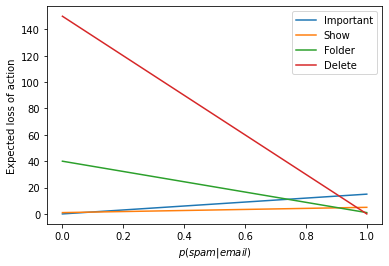

In [5]:
losses = [[15, 0],[5, 1], [1, 40],[0, 150]]
actions_names = ['Important','Show', 'Folder', 'Delete']
num_actions = len(losses)
def expected_loss_of_action(prob_spam, action):
    #TODO: Return expected loss over a Bernoulli random variable
    # with mean prob_spam.
    # Losses are given by the table above.
    return losses[action][0]*prob_spam + losses[action][1]*(1 - prob_spam)
    
prob_range = np.linspace(0., 1., num=600) 

# Make plot
for action in range(num_actions):
    print(str(action))
    plt.plot(prob_range, expected_loss_of_action(prob_range, action), label=actions_names[action])

plt.xlabel('$p(spam|email)$')
plt.ylabel('Expected loss of action')
plt.legend()


In [8]:
def optimal_action(prob_spam):
    #TODO: return best action given the probability of spam. 
    #Hint: np.argmin might be helpful.
    losses = []
    for action in range(num_actions):
      losses.append(expected_loss_of_action(prob_spam, action))
    return np.argmin(losses)

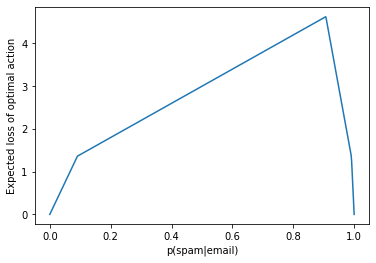

In [9]:
prob_range = np.linspace(0., 1., num=600) 
optimal_losses = []
optimal_actions = []
for p in prob_range:
    # TODO: Compute the optimal action and its expected loss for
    # probability of spam given by p.
    found_optimal_action = optimal_action(p)
    optimal_actions.append(found_optimal_action)
    optimal_losses.append(expected_loss_of_action(p, found_optimal_action))

plt.xlabel('p(spam|email)')
plt.ylabel('Expected loss of optimal action')
plt.plot(prob_range, optimal_losses)


$\mathbb{E}[loss|important] = p(spam)*15 + (1 - p(spam))*0 = p(spam)*15$

$\mathbb{E}[loss|show] = p(spam)*5 + (1 - p(spam))*1 $

$\mathbb{E}[loss|folder] = p(spam)*1 + (1 - p(spam))*40$

$\mathbb{E}[loss|delete] = p(spam)*0 + (1 - p(spam))*150 = (1-p(spam))*150$

We check when $\mathbb{E}[loss|delete]$ intersects with the other expected losses.

$\mathbb{E}[loss|important] = \mathbb{E}[loss|delete] \Leftrightarrow p(spam)*15 = (1-p(spam))*150 \Leftrightarrow p(spam) = (1-p(spam))*10 ⇔ p(spam) = \frac{10}{11}$

$\mathbb{E}[loss|show] = \mathbb{E}[loss|delete] ⇔ p(spam)*5 + (1 - p(spam)) = (1-p(spam))*150 ⇔ p(spam) = \frac{149}{154}$

$\mathbb{E}[loss|folder] = \mathbb{E}[loss|delete] ⇔ p(spam)*1 + (1 - p(spam))*40 = (1-p(spam))*150 ⇔ p(spam) = \frac{110}{111}$

Now notice that $\mathbb{E}[loss|delete]$ and $\mathbb{E}[loss|folder]$ are decreasing functions on $\mathbb{R}$ while $\mathbb{E}[loss|important]$ and $\mathbb{E}[loss|show]$ are increasing. Of these three intersections, the one with highest expected value is with the folder action at $p(spam) = \frac{110}{111}$. Thus we should delete an email only when $p(spam) \in [\frac{110}{111}, 1]$.


Naïve Bayes, A Generative Model

![](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true)

Fashion MNIST is a dataset of 28x28 black-and-white images of items of clothing. We represent each image by a vector $x^{(i)} \in \{0,1\}^{784}$, where 0 and 1 represent white and black pixels respectively. Each class label $c^{(i)}$ is a different item of clothing, which in the code is represented by a 10-dimensional one-hot vector.

The Naïve Bayes model parameterized by $\theta$ and $\pi$ defines the following joint probability of $x$ and $c$,
$$p(x,c|\theta,\pi) = p(c|\pi)p(x|c,\theta) = p(c|\pi)\prod_{j=1}^{784}p(x_j|c,\theta),$$
where $x_j | c,\theta \sim \operatorname{Bernoulli}(\theta_{jc})$ or in other words $p(x_j | c,\theta) = \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}$, and $c|\pi$ follows a simple categorical distribution, i.e. $p(c|\pi) = \pi_c$.

We begin by learning the parameters $\theta$ and $\pi$. 

In [3]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')
    # Remove the data point that cause log(0)
    remove = (14926, 20348, 36487, 45128, 50945, 51163, 55023)
    train_images = np.delete(train_images,remove, axis=0)
    train_labels = np.delete(train_labels, remove, axis=0)
    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_fashion_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels =  fashion_mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels


We want to maximize

$L(\theta,\pi) = \prod_{i=1}^{N}p(x^{(i)},c^{(i)}|\theta,\pi)$.

Apply log function to optimize a concave function:

$\log L(\theta,\pi) = \sum_{i=1}^{N} \log p(x^{(i)},c^{(i)}|\theta,\pi) \\
= \sum_{i=1}^{N} \log p(c^{(i)}|\pi) + \sum_{i=1}^{N} \sum_{j=1}^{784}\log p(x^{(i)}_j|c^{(i)},\theta)$



$$\log L(\theta,\pi) = \sum_{i=1}^{N} \log \pi_{c^{(i)}} + \sum_{i=1}^{N} \sum_{j=1}^{784} x^{(i)}j \log \theta{c^{(i)}j} + (1 - x^{(i)}j) \log (1-\theta{c^{(i)}j})$$

The MLE of $\theta_{cj}$ and $\pi_c$ is found by optimizing the log likelihood wrt to $\theta_{cj}$ and $\pi_c$ respectively.

For $\theta_{cj}$:
$$\frac{\partial \log L(\theta,\pi)}{\partial \theta_{cj}} = \sum_{i=1}^{N} [x^{(i)}_j - \theta{c^{(i)}_j}] = 0 \Rightarrow \hat{\theta}_{cj} = \frac{\sum_{i=1}^{N}x^{(i)}_j c_k^{(i)}}{\sum_{i=1}^{N} x_j ^{(i)}}$$

For $\pi_c$:
$$\frac{\partial \log L(\theta,\pi)}{\partial \pi_c} = \sum_{i=1}^{N} [\frac{1}{\pi_c} - \frac{1}{\pi_{c^{(i)}}}] = 0 \Rightarrow \hat{\pi}_c = \frac{\sum_{i=1}^{N} c_k^{(i)}}{N}$$




Assume the prior distribution of $\theta$ is such that the entries are i.i.d. and drawn from $\operatorname{Beta}(2,2)$. 


Let the prior distribution of $\theta_{cj}$ ~ $\operatorname{Beta}(2,2)$, i.e. $\alpha = \beta = 2$. Then the posterior distribution of $\theta_{cj}$ is:

$$p(\theta_{cj} | x, c) \propto p(x,c | \theta_{cj})p(\theta_{cj}) = \left(\prod_{i=1}^{N}p(x^{(i)}j | c^{(i)}, \theta{cj})\right)p(\theta_{cj}) = \left(\prod_{i=1}^{N} \theta_{cj}^{x^{(i)}j}(1-\theta{cj})^{1-x^{(i)}_j}\right)\operatorname{Beta}(2,2)$$

where $p(x^{(i)}j | c^{(i)}, \theta{cj}) = \theta_{cj}^{x^{(i)}j}(1-\theta{cj})^{1-x^{(i)}_j}$.

We want to maximize this. 
Apply log function and differentiate wrt $\theta_{jc}$ to maximize. We get: 


$$ \sum_{i=1}^N log p (x^{(i)}, c^{(i)} | \theta^{(i)}, \pi)+ log p (\theta^{(i)}) + C$$ where $C$ is a constant

$$= \sum_{i=1}^N [log(1 - \theta_{jc}^{(i)}) + log_\pi^{(i)} + [\sum_{j=1}^{784} x_j^{(i)}log \theta_j^{(i)} + (1 - x_j^{(i)}) log (1-\theta_{jc}^{(i)}) + log \theta_{jc}^{(i)}]] + C$$
Let
$$\frac{\partial logp(\theta_{jc} | x, c)}{\partial \theta_{jc}} = 0  $$

$$⇔ \sum_{i=1}^N c^{(i)}_j (\frac{x_j^{(i)}}{\theta_{jc}} - \frac{1 - x_j^{(i)}}{1 - \theta_{jc}}) + \frac{\alpha - 1}{\theta_{jc}} - \frac{\beta - 1}{1 - \theta_{jc}} = 0$$

$$⇔ \hat{\theta}_{jc} = \frac{1 + \sum_{i=1}^{N} c_k^{(i)}x_j^{(i)}}{2 + \sum_{i=1}^{N} c_k^{(i)}}$$ is the MAP estimator for $\theta_{jc}$.



In [4]:
def train_map_estimator(train_images, train_labels):
    """ Inputs: train_images (N_samples x N_features), train_labels (N_samples x N_classes)
        Returns the MAP estimator theta_est (N_features x N_classes) and the MLE
        estimator pi_est (N_classes)"""
    
    N_samples, N_features = train_images.shape
    N_classes = train_labels.shape[1]
    
    theta_est = np.zeros((N_features, N_classes))
    pi_est = np.zeros(N_classes)
    
    for c in range(N_classes):
        class_images = train_images[train_labels[:,c] == 1,:]
        class_pi_est = class_images.shape[0]/N_samples
        pi_est[c] = class_pi_est
        
        for j in range(N_features):
            alpha = 2 + np.sum(class_images[:,j])
            beta = 2 + class_images.shape[0] - np.sum(class_images[:,j])
            theta_est[j,c] = alpha / (alpha + beta)
    
    return theta_est, pi_est


The class log-likelihood $\log p(c|x,\theta,\pi)$ for a single image:


By Bayes' rule:

$$p(c|x,\theta,\pi) = \frac{p(x|c,\theta)p(c|\pi)}{\sum_{c'=1}^{K}p(x|c',\theta)p(c'|\pi)}$$

Now apply the log function:

$$\log p(c|x,\theta,\pi) = \log p(x|c,\theta) + \log p(c|\pi) - \log \sum_{c'=1}^{K}p(x|c',\theta)p(c'|\pi)$$

Since $p(x|c,\theta) = \prod_{j=1}^{784}p(x_j|c,\theta)$,

$$\log p(x|c,\theta) = \sum_{j=1}^{784}\log p(x_j|c,\theta)$$

And since $p(c|\pi) = \pi_c$, 

$$\log p(c|\pi) = \log \pi_c$$

Thus the class log-likelihood $logp(c|x,θ,π)$ is:

$$\log p(c|x,\theta,\pi) = \sum_{j=1}^{784}\log p(x_j|c,\theta) + \log \pi_c - \log \sum_{c'=1}^{K}p(x|c',\theta)p(c'|\pi)$$

$$= \sum_{j=1}^{784}\log p(x_j|c,\theta) - log(\sum_{i=1}^{10} p (c_i = 1 | \pi) \Pi_{j=1}^{784} p( x_j | c_i = 1, \pi, \theta))$$


In [5]:
def log_likelihood(images, theta, pi):
    """ Inputs: images (N_samples x N_features), theta, pi
        Returns the matrix 'log_like' of loglikehoods over the input images where
        log_like[i,c] = log p (c |x^(i), theta, pi) using the estimators theta and pi.
        log_like is a matrix of (N_samples x N_classes)
    Note that log likelihood is not only for c^(i), it is for all possible c's."""

    N_samples, N_features = images.shape
    N_classes = pi.shape[0]
    
    log_like = np.zeros((N_samples, N_classes))
    for i in range(N_samples):
        for c in range(N_classes):
            log_p_c = np.log(pi[c])
            log_p_x = np.sum(np.log(theta[:,c])*images[i,:] + np.log(1-theta[:,c])*(1-images[i,:]))
    
            # check for images that cause errors
            #if log_p_c == 0 or log_p_x == 0:
              #print(i)
              #pass

            log_like[i,c] = log_p_c + log_p_x
    
    log_like -= np.log(np.sum(np.exp(log_like), axis=1))[:, np.newaxis]
    
    return log_like
 


def accuracy(log_like, labels):
    """ Inputs: matrix of log likelihoods and 1-of-K labels (N_samples x N_classes)
    Returns the accuracy based on predictions from log likelihood values"""

    N_samples = labels.shape[0]
    predictions = np.argmax(log_like, axis=1)
    true_labels = np.argmax(labels, axis=1)
    accuracy = np.mean(predictions == true_labels)
    return accuracy


N_data, train_images, train_labels, test_images, test_labels = load_fashion_mnist()
theta_est, pi_est = train_map_estimator(train_images, train_labels)

loglike_train = log_likelihood(train_images, theta_est, pi_est)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = log_likelihood(test_images, theta_est, pi_est)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MAP is {avg_loglike:.3f}")
print(f"Training accuracy for MAP is {train_accuracy:.3f}")
print(f"Test accuracy for MAP is {test_accuracy:.3f}")

Average log-likelihood for MAP is -34.350
Training accuracy for MAP is 0.651
Test accuracy for MAP is 0.637


For the the Naive Bayes model, by assumption, since by assumption given the class label c, all pixels are independent. So the joint probability of two pixels $x_i$ and $x_j$ given class label c can be expressed as $p(x_i, x_j | c) = p(x_i | c) * p(x_j | c)$.

After marginalizing over c, no. The marginal probability $p(x_i, x_j)$ depends on both $p(x_i | c)$ and $p(x_j | c)$ for all c. Then there must also be dependencies between $x_i$ and $x_j$. 

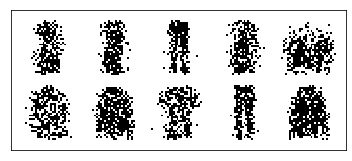

In [6]:
def image_sampler(theta, pi, num_images):
    """ Inputs: parameters theta and pi, and number of images to sample
    Returns the sampled images (N_images x N_features)"""


    N_classes = theta.shape[1]
    N_features = theta.shape[0] # number of pixels

    sampled_images = np.zeros((num_images, N_features))
    
    for i in range(num_images):

      # Sample the class
      c = np.random.choice(pi.shape[0], p=pi)
        
      # Sample the pixels conditioned on the class
      for j in range(N_features):
        sampled_images[i, j] = np.random.binomial(1, theta[j, c])

    return sampled_images
            


def plot_images(images, ims_per_row=5, padding=5, image_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((image_dimensions[0] + padding) * N_rows + padding,
                             (image_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], image_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + image_dimensions[0]) * row_ix
        col_start = padding + (padding + image_dimensions[1]) * col_ix
        concat_images[row_start: row_start + image_dimensions[0],
                      col_start: col_start + image_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    plt.plot()


sampled_images = image_sampler(theta_est, pi_est, 10)
plot_images(sampled_images)



By Bayes' rule:

$$p(x_j|x_E,\theta,\pi) = \frac{p(x_E,x_j|\theta,\pi)}{p(x_E|\theta,\pi)} $$

We marginalize over $c$ to find $p(x_E,x_j|\theta,\pi)$:

$$= \frac{\sum_c p(x_E,x_j,c|\theta,\pi)}{p(x_E|\theta,\pi)}$$

$$= \frac{\sum_c p(x_j|c,\theta)p(x_E,c|\theta, \pi)}{p(x_E|\theta,\pi)} $$

$$= \frac{\sum_c p(x_j|c,\theta)p(x_E,c|\theta, \pi)}{\sum_c p(x_E,c|\theta,\pi)} $$

$$= \frac{\sum_c p(x_j|c,\theta)p(x_E,c|\theta, \pi)}{\sum_c p(x_E|c,\theta)p(c|\pi)} $$This is the conditional probability of an unobserved pixel $j$ given observed pixels, class, and the distribution parameters.



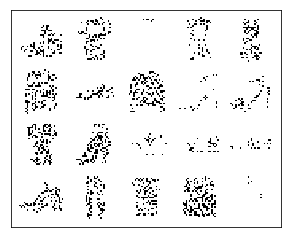

In [31]:
def probabilistic_imputer(theta, pi, original_images, is_observed):
    """Inputs: parameters theta and pi, original_images (N_images x N_features), 
        and is_observed which has the same shape as original_images, with a value
        1. in every observed entry and 0. in every unobserved entry.
    Returns the new images where unobserved pixels are replaced by their 
    conditional probability"""
    
    N_images, N_features = original_images.shape
    new_images = original_images.copy()

    for i in range(N_images):
        for j in range(N_features):

            if not is_observed[i, j]:

                numerator = 0.1
                denominator = 0.1

                for c in range(len(pi)):

                    prob_xj = theta[j][c]*original_images[i][j]
                    prob_xE = pi[c]
                    prob_c = pi[c]
                    
                    numerator += prob_xj * prob_xE
                    denominator += prob_xE

                new_images[i][j] = numerator / denominator

    return new_images


num_features = train_images.shape[1]
is_observed = np.random.binomial(1, p=0.3, size=(20, num_features))
plot_images(train_images[:20] * is_observed)


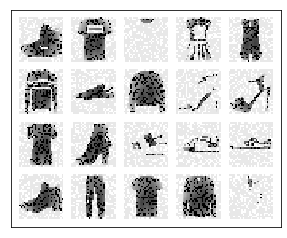

In [32]:
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images[:20], is_observed)
plot_images(imputed_images)